## SQL

Tables:
- `accounts` - Facebook public profiles with some data on them
- `posts` - posts of these public profiles, you can use the profile_id column to connect to
the accounts table
- `sources_for_followers` - number of followers for these public profiles

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [2]:
db_params = {
    'host': 'localhost',
    'port': 5432,
    'database': 'postgres',
    'user': 'postgres',
    'password': 'postgres_password'
}

In [3]:
engine = create_engine(f'postgresql://{db_params["user"]}:{db_params["password"]}@{db_params["host"]}/{db_params["database"]}')

In [4]:
csv_files = {
    'accounts': 'datasets/accounts.csv',
    'posts': 'datasets/posts.csv',
    'sources_for_followers': 'datasets/sources_for_followers.csv'
}

In [5]:
for table_name, file_path in csv_files.items():
    df = pd.read_csv(file_path)
    df.to_sql(table_name, engine, if_exists='replace', index=False)

Let's see the info of every table.

In [6]:
for table_name in csv_files.keys():
    query = f"""SELECT *              
               FROM {table_name};"""
    table = pd.read_sql(query, engine)
    print(f'Information about {table_name} table:')
    print(table.info(), '\n')

Information about accounts table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           30 non-null     int64  
 1   username     28 non-null     object 
 2   full_name    30 non-null     object 
 3   description  28 non-null     object 
 4   is_verified  27 non-null     object 
 5   restricted   0 non-null      object 
 6   _id          30 non-null     int64  
 7   _status      30 non-null     object 
 8   id_alt       3 non-null      float64
dtypes: float64(1), int64(2), object(6)
memory usage: 2.2+ KB
None 

Information about posts table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1138 non-null   int64 
 1   created_time    1138 non-null   object
 2   profile_id     

The `accounts` table contains 30 records, with some columns having missing values, and the `restricted` column being entirely empty.
The `posts` table consists of 1138 records, with all fields fully populated.
The `sources_for_followers` table contains 30 records, with all fields fully populated.

We will analyze these tables in more detail later.

Let's check if we can match all records by account id.

In [7]:
query = """SELECT COUNT(*)        
           FROM accounts AS a
           FULL JOIN sources_for_followers AS s
           ON a._id = s._id
           FULL JOIN posts as p
           ON a.id = p.profile_id
           WHERE a.id IS NULL OR s._id is NULL OR p.id IS NULL;"""
print(pd.read_sql(query, engine))

   count
0    120


After merging, we have 120 records where either the account id or post id is missing, or the account ID comes from the `sources_for_followers` table.

Let's see if each account has details about its follower count.

In [8]:
query = """SELECT COUNT(*)              
           FROM accounts
           LEFT JOIN sources_for_followers
           USING(_id)
           WHERE followers_count IS NULL;"""
print(pd.read_sql(query, engine))

   count
0      0


We need to check if we have information on all post authors.

In [9]:
query = """SELECT DISTINCT profile_id       
           FROM posts AS p
           LEFT JOIN accounts AS a
           ON p.profile_id = a.id
           WHERE a.id IS NULL;"""
print(pd.read_sql(query, engine))

         profile_id
0   100064141090703
1  2212856535602171
2   100064478088503


We have three post authors missing from the `accounts` table. However, the `accounts` table includes a column called `id_alt`, so let's check if we can use this column.


In [10]:
query = """SELECT id_alt        
           FROM accounts AS a
           WHERE id_alt IS NOT NULL;"""
print(pd.read_sql(query, engine).astype(int))

             id_alt
0   100064141090703
1  2212856535602171
2   100064478088503


Now we can merge all our data, keeping the result for future analysis.

In [11]:
query = """SELECT a.*, s.followers_count, p.id AS post_id, p.created_time AS post_created_time, 
                  p.text_original AS post_text, p.comments_count
           FROM accounts AS a
           LEFT JOIN sources_for_followers AS s
           ON a._id = s._id
           LEFT JOIN posts as p
           ON a.id = p.profile_id OR a.id_alt = p.profile_id;"""
accounts_with_posts_data = pd.read_sql(query, engine)

It will be easier for us to work with two separate tables, `accounts` and `posts`, so we will store them in DataFrames.

In [12]:
query = """SELECT a.*, s.followers_count
           FROM accounts AS a
           LEFT JOIN sources_for_followers AS s
           ON a._id = s._id;"""
accounts_with_followers = pd.read_sql(query, engine)

In [13]:
query = """SELECT *              
           FROM posts;"""
posts = pd.read_sql(query, engine)

## EDA

In [14]:
accounts_with_followers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               30 non-null     int64  
 1   username         28 non-null     object 
 2   full_name        30 non-null     object 
 3   description      28 non-null     object 
 4   is_verified      27 non-null     object 
 5   restricted       0 non-null      object 
 6   _id              30 non-null     int64  
 7   _status          30 non-null     object 
 8   id_alt           3 non-null      float64
 9   followers_count  30 non-null     int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 2.5+ KB


In [15]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1138 non-null   int64 
 1   created_time    1138 non-null   object
 2   profile_id      1138 non-null   int64 
 3   text_original   1138 non-null   object
 4   comments_count  1138 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 44.6+ KB


### Data Cleaning

During the overview, we observed that the `restricted` column is completely empty, the `_status` column contains the same value in all rows, and the `_id` column does not provide any meaningful information. Therefore, we can remove these columns.

In [16]:
columns_to_drop = ['_id', 'restricted', '_status']
accounts_with_followers = accounts_with_followers.drop(columns=columns_to_drop)

We will fill missing values in the `username` and `description` columns with an `unknown`, in the `is_verified`  with `False`, and in the `id_alt` with `id`.

In [17]:
accounts_with_followers[['username', 'description']] = (
    accounts_with_followers[['username', 'description']].fillna('unknown')
)
accounts_with_followers['is_verified'] = accounts_with_followers['is_verified'].fillna('False')
accounts_with_followers['id_alt'] = accounts_with_followers['id_alt'].fillna(accounts_with_followers['id'])

#remove "group/" from username
accounts_with_followers['username'] = accounts_with_followers['username'].str.replace(r'^group/', '', regex=True)

Let's fix the data types in the `is_verified`, `id_alt` columns in the `account_with_followers` table; and the `created_time` column in the `posts` table.

In [18]:
accounts_with_followers['is_verified'] = accounts_with_followers['is_verified'].astype(bool)
accounts_with_followers['id_alt'] = accounts_with_followers['id_alt'].astype(int)
posts['created_time'] = pd.to_datetime(posts['created_time'])

In [19]:
print('Count duplicates in the accounts_with_followers table:', accounts_with_followers.duplicated().sum())
print('Count duplicates in the posts table:', posts.duplicated().sum())

Count duplicates in the accounts_with_followers table: 0
Count duplicates in the posts table: 0


### Analyzing the data

Analyzing the `is_verified` column

In [20]:
percent_verified = (accounts_with_followers['is_verified'].value_counts(normalize=True) * 100).round(1)

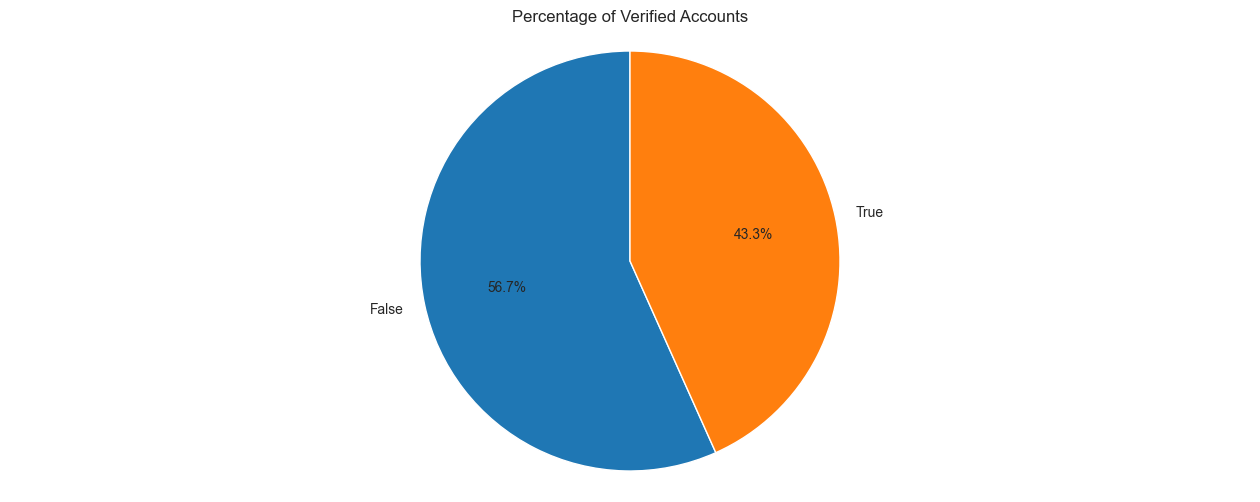

In [21]:
plt.figure(figsize=(16, 6))
plt.pie(percent_verified, labels=percent_verified.index.astype(str), autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Verified Accounts')
plt.axis('equal')
plt.show()

We have 43.3% verified and 56.7% unverified accounts in our dataset.

Analyzing the `followers_count` column

In [22]:
accounts_with_followers['followers_count'].describe().astype(int)

count         30
mean      217936
std       313692
min        22600
25%        41500
50%        75500
75%       150728
max      1200000
Name: followers_count, dtype: int64

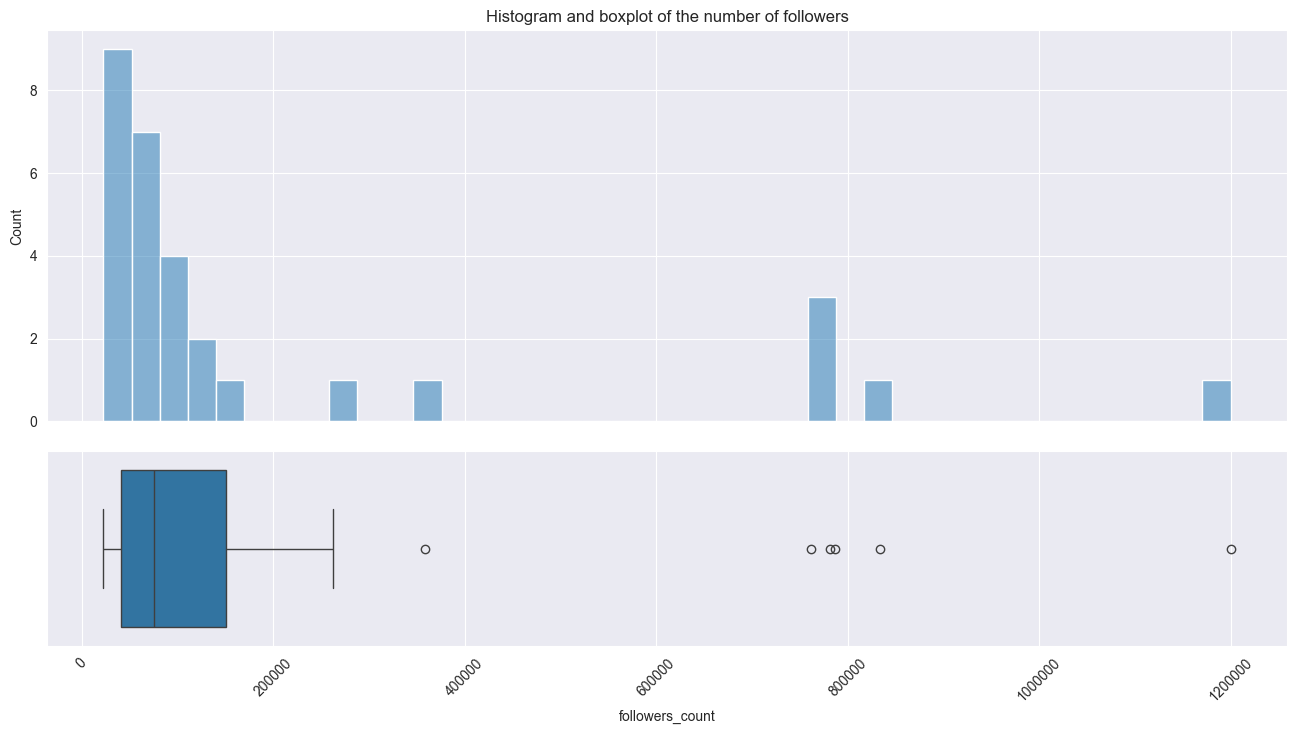

In [23]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 8), gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(hspace=0.1)
ax1.set_title('Histogram and boxplot of the number of followers')
sns.histplot(data=accounts_with_followers, x='followers_count',
                   ax=ax1, bins=40, alpha=0.5)
sns.boxplot(data=accounts_with_followers, x='followers_count', ax=ax2)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.show()

Most accounts have a follower count of up to 300,000. There are a few accounts with follower counts ranging from 700,000 to 850,000, and there is one account with over one million followers.

Let's analyze the `posts` data. We will add new date columns to identify various posting patterns.

In [24]:
posts['created_hour'] = posts['created_time'].dt.hour
posts['created_date'] = posts['created_time'].dt.date
posts['created_day_of_week'] = posts['created_time'].dt.day_name()

In [25]:
posts['created_time'].describe()

count                                   1138
mean     2023-04-08 02:25:33.699472640+00:00
min                2022-12-01 11:56:58+00:00
25%      2023-04-03 06:42:04.249999872+00:00
50%         2023-04-21 05:57:15.500000+00:00
75%         2023-04-23 18:16:55.500000+00:00
max                2023-04-24 14:34:06+00:00
Name: created_time, dtype: object

Our data includes posts with creation dates ranging from December 1, 2022, to April 24, 2023.

Let's identify the days and hours when people post the most frequently.

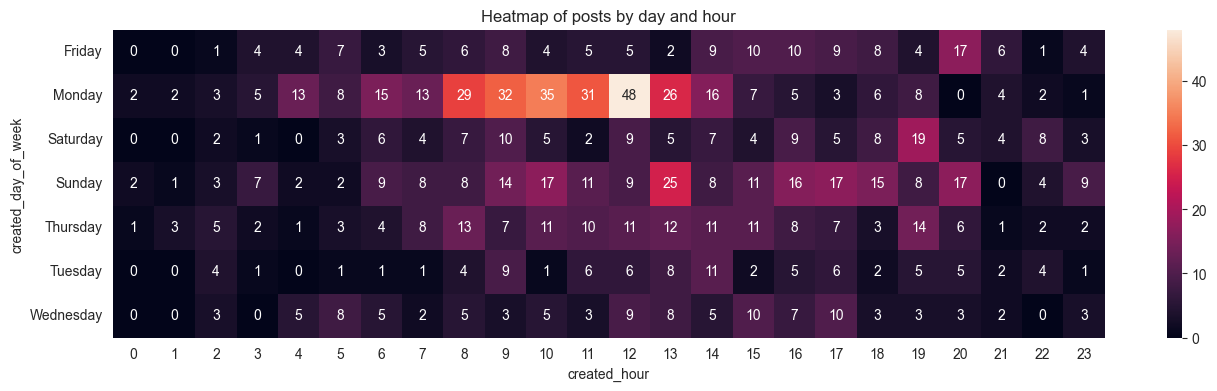

In [26]:
pivot_table = posts.pivot_table(index='created_day_of_week', columns='created_hour', values='created_date', aggfunc='count', fill_value=0)
plt.figure(figsize=(16, 4))
sns.heatmap(pivot_table, annot=True, fmt='d')
plt.title('Heatmap of posts by day and hour')
plt.show()

The heatmap shows that the most popular time for posting is Monday between 8 AM and 1 PM.

Let's explore how posting behavior has shifted over time.

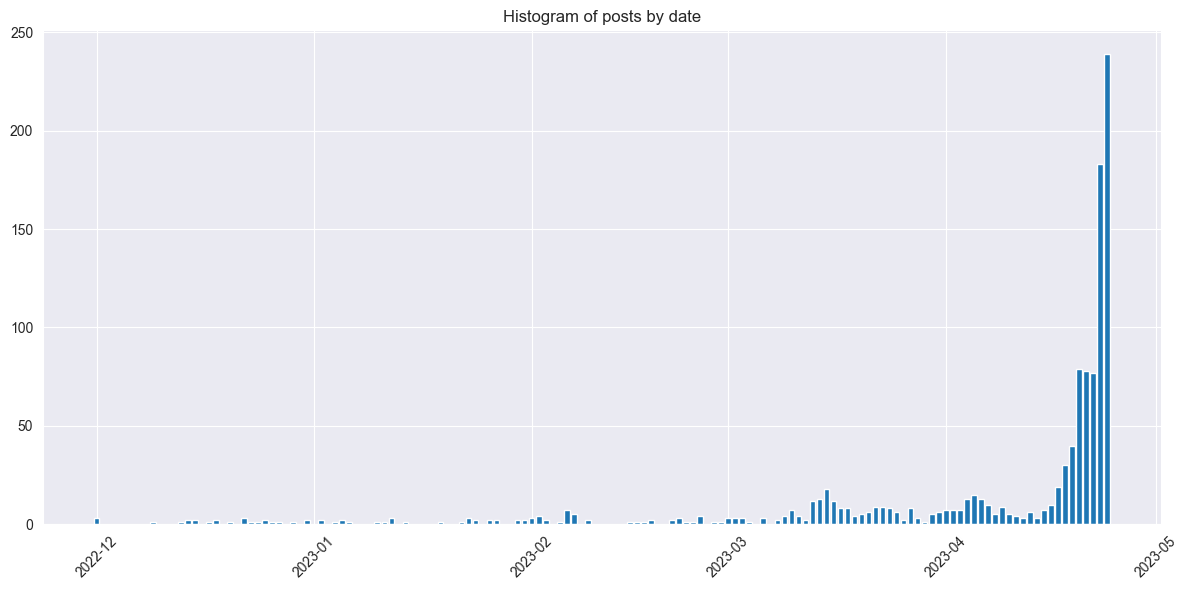

In [27]:
date_counts = posts['created_date'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(date_counts.index, date_counts.values)
plt.title('Histogram of posts by date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

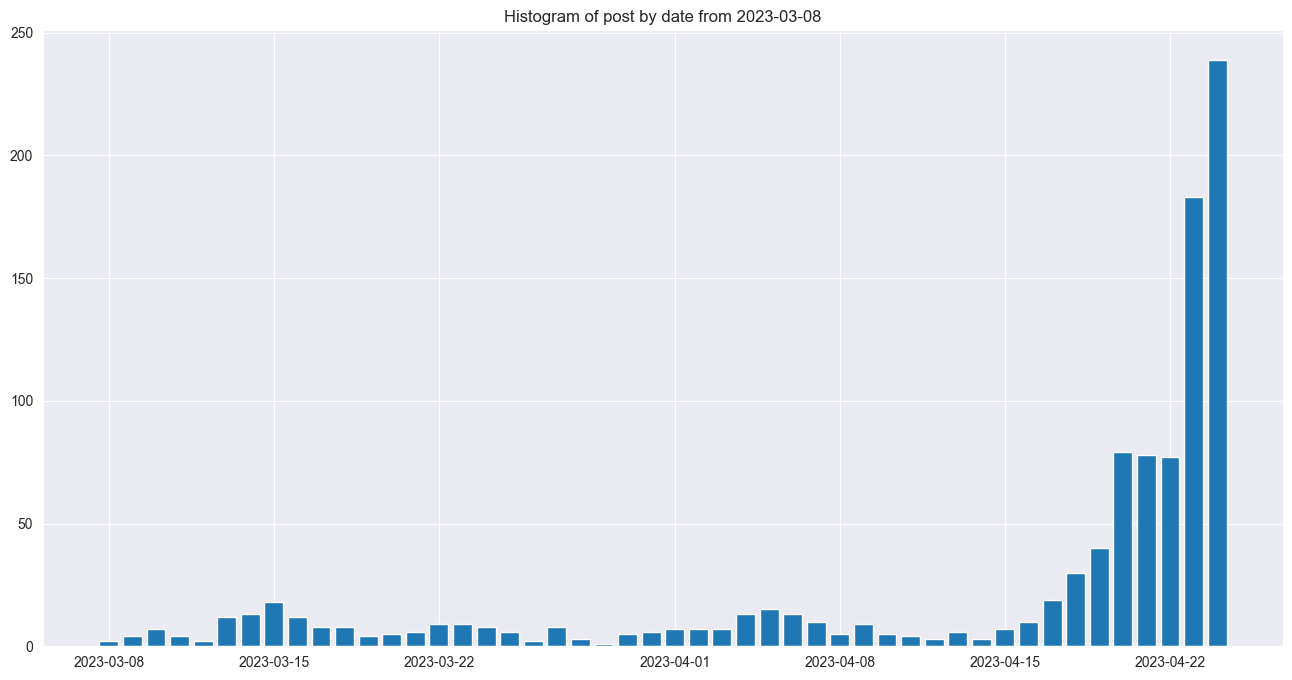

In [28]:
start_date_hist = pd.to_datetime('2023-03-08').date()
filtered_date_counts = date_counts[(date_counts.index >= start_date_hist)]

plt.figure(figsize=(16, 8))
plt.bar(filtered_date_counts.index, filtered_date_counts.values)
plt.title('Histogram of post by date from 2023-03-08')
plt.show()

We can say that since April 17, there has been a noticeable abnormal increase in posting. Let’s dive into this in more detail.

In [29]:
start_date = pd.to_datetime('2022-12-01').date()
end_date = pd.to_datetime('2023-04-24').date()
trend_start_date = pd.to_datetime('2023-04-17').date()

days_between_trend_and_start = (trend_start_date - start_date).days
days_between_end_and_trend = (end_date - trend_start_date).days

posts_before_trend_start_date = posts[posts['created_date'] < trend_start_date]
posts_after_trend_start_date = posts[posts['created_date'] >= trend_start_date]

print(f'Average posts per day before April 17: '
      f'{len(posts_before_trend_start_date) / days_between_trend_and_start:.1f}')
print(f'Average posts per day after April 17: {len(posts_after_trend_start_date) / days_between_end_and_trend:.1f}')
print('\n')
print(f'Percentage of all posts before April 17: {(len(posts_before_trend_start_date)/ len(posts)):.2%}')
print(f'Percentage of all posts after April 17: {(len(posts_after_trend_start_date)/ len(posts)):.2%}')

Average posts per day before April 17: 2.9
Average posts per day after April 17: 106.4


Percentage of all posts before April 17: 34.53%
Percentage of all posts after April 17: 65.47%


Therefore, we can confidently conclude that posting behavior has significantly shifted, with a 37-fold increase in activity.

Let's look at the heatmap again, but exclude the data after April 17 (including).

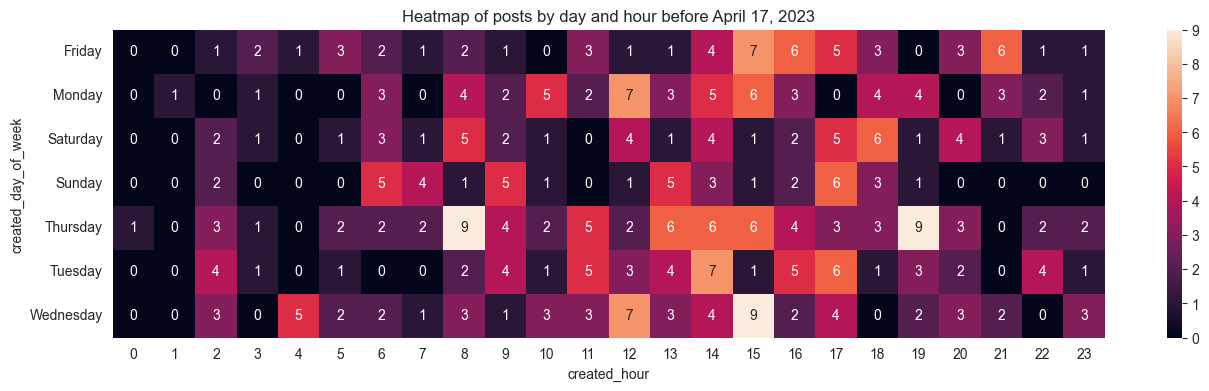

In [30]:
pivot_table = posts_before_trend_start_date.pivot_table(index='created_day_of_week', columns='created_hour', values='created_date', aggfunc='count', fill_value=0)
plt.figure(figsize=(16, 4))
sns.heatmap(pivot_table, annot=True, fmt='d')
plt.title('Heatmap of posts by day and hour before April 17, 2023')
plt.show()

From this chart, we can't conclude that there is any clear pattern in the posting behavior.

In [31]:
posts.groupby('profile_id')['id'].count()

profile_id
1575860640          39
154719474224        39
182549563410         7
100039658642469     39
100044386691134     39
100044566592485     39
100049129852371     39
100051217200820     39
100063477739510     39
100063622184348     39
100063695660293     39
100063937567968     39
100064141090703     39
100064478088503     39
100064603219571     39
100064628534852     39
100064898132087     39
100068846905135     39
100069390481601     39
133283433353535     39
138513176208770     39
144698628932572     39
233946916972658     39
248236578706001     39
787994435289379     39
960138591245808     39
1424889777766065    39
1433810553594661    39
1492252324350852    39
2212856535602171    39
Name: id, dtype: int64

Interestingly, all but one account posted 39 times throughout the entire study period.

Let's analyze the `comments_count` column.

In [32]:
posts['comments_count'].describe()

count    1138.000000
mean       11.329525
std        33.499412
min         0.000000
25%         0.000000
50%         0.000000
75%         6.000000
max       447.000000
Name: comments_count, dtype: float64

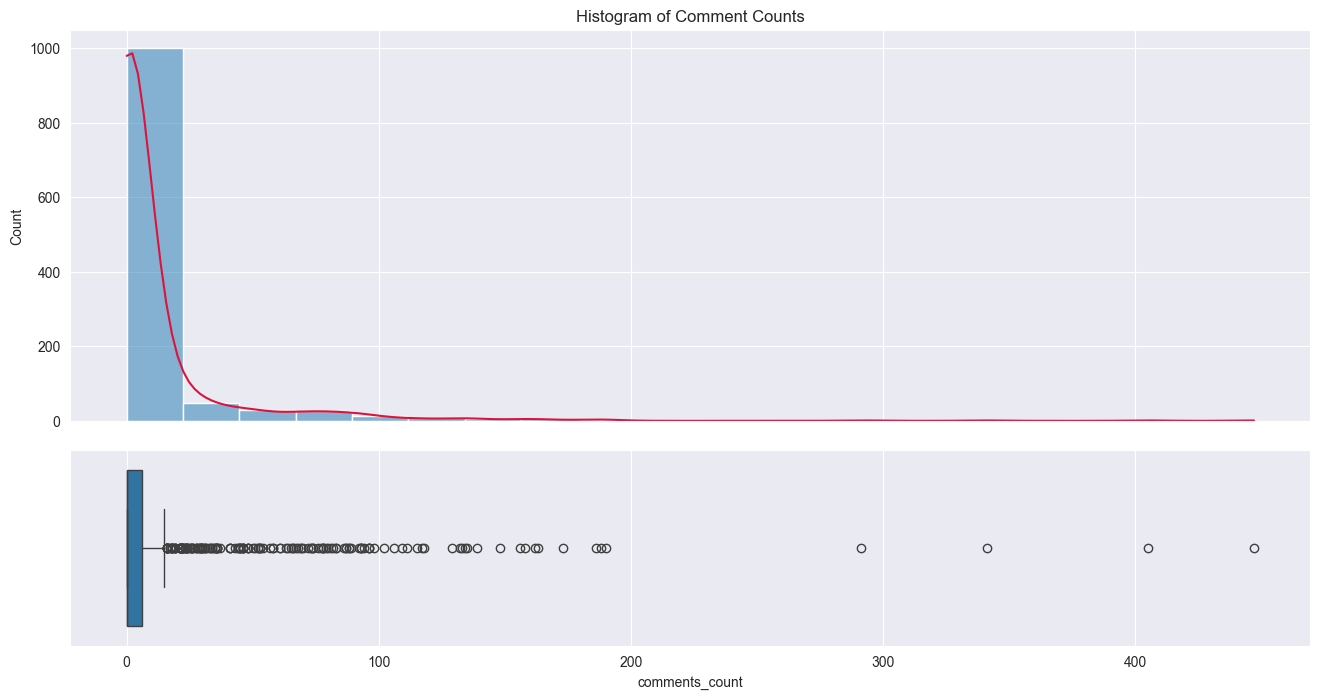

In [33]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 8), gridspec_kw={'height_ratios': [2, 1]})
plt.subplots_adjust(hspace=0.1)
ax1.set_title('Histogram of Comment Counts')
sns.histplot(data=posts, x='comments_count', 
             ax=ax1, common_bins=True, bins=20, alpha=0.5,
             kde=True)
ax1.lines[0].set_color('crimson')
sns.boxplot(data=posts, x='comments_count', ax=ax2)
plt.show()

The data has a skewed distribution where many posts receive no engagement, some posts receive significantly more comments than others. One assumption is that this abnormal difference in engagement is due to the bot activity.

Let’s explore whether page activity is related to the number of followers.

In [34]:
comments_count_per_account = posts.groupby('profile_id')['comments_count'].sum().reset_index()
accounts_with_comments = pd.merge(accounts_with_followers, comments_count_per_account, left_on='id_alt', right_on='profile_id', how='left')

In [35]:
print(f"Correlation between the number of followers and the number of comments on all account posts: "
      f"{accounts_with_comments['followers_count'].corr(accounts_with_comments['comments_count']):.2f}")

Correlation between the number of followers and the number of comments on all account posts: -0.01


As we can see, there is no correlation.

Let's explore whether there is a correlation between post length and engagement.

In [36]:
posts['text_len'] = posts['text_original'].apply(len)

In [37]:
print(f"Correlation between the post length and the number of comments: "
      f"{posts['text_len'].corr(posts['comments_count']):.2f}")

Correlation between the post length and the number of comments: -0.08


There is no correlation.

In [38]:
top_10_posts = posts.nlargest(10, 'comments_count')
top_10_posts

,id,created_time,profile_id,text_original,comments_count,created_hour,created_date,created_day_of_week,text_len
63,734562668126038,2023-02-21 09:01:54+00:00,100049129852371,خطاب ينتظره العالم.. هل يغير بوتين مسار العملي...,447,9,2023-02-21,Tuesday,100
66,724211798875802,2022-12-31 20:50:40+00:00,100049129852371,بوتين يوجه رسالة هامة للروس والعالم بحلول العا...,405,20,2022-12-31,Saturday,54
635,823098289181058,2023-04-24 10:33:43+00:00,100063622184348,Avertizare de vuftuni violente și fenomene met...,341,10,2023-04-24,Monday,60
126,971856574169866,2022-12-27 17:00:10+00:00,100069390481601,📌 Putin prohíbe el suministro de crudo ruso a ...,291,17,2022-12-27,Tuesday,238
160,921428155659740,2023-03-18 23:08:15+00:00,100069390481601,"En 1938, el presidente Lázaro Cárdenas expidió...",190,23,2023-03-18,Saturday,184
158,922367548972273,2023-04-15 20:34:29+00:00,100069390481601,"El presidente ruso, Vladímir Putin, ha llegado...",188,20,2023-04-15,Saturday,134
138,945982783055944,2022-12-31 22:01:06+00:00,100069390481601,❗️Llega el 2023 a todo el territorio ruso y a ...,186,22,2022-12-31,Saturday,243
72,691777352335383,2022-12-22 15:48:57+00:00,100049129852371,المؤتمر الصحفي للرئيس الروسي فلاديمير بوتين,173,15,2022-12-22,Thursday,43
1072,760363682114331,2023-03-16 11:44:37+00:00,2212856535602171,"‼️KÖZLEMÉNY! Engem is utolért a cenzúra, az el...",163,11,2023-03-16,Thursday,373
1096,756800695803963,2023-03-09 15:28:57+00:00,2212856535602171,"🤯Ezt már tényleg nem hiszem el! Azok után, hog...",162,15,2023-03-09,Thursday,129


Posts written in Arabic and Spanish received the highest number of comments.

In [39]:
top_5_accounts = accounts_with_comments.nlargest(5, 'comments_count')
bottom_5_accounts = accounts_with_comments.nsmallest(5, 'comments_count')

In [40]:
top_5_accounts

,id,username,full_name,description,is_verified,id_alt,followers_count,profile_id,comments_count
9,100069390481601,unzensuriert,unzensuriert.at,"Demokratisch, kritisch, polemisch und selbstve...",False,100069390481601,58000,100069390481601,3853
28,100049129852371,Prüfe-alles-glaube-wenig-denke-selbst,"Prüfe alles, glaube wenig, denke selbst.",🙂 https://t.me/pruefealles & 🎬 https://rumble....,False,100049129852371,74000,100049129852371,2663
13,100044563410651,george.simion.unire,George Simion,ROMÂNIA MARE ÎN EUROPA!,True,2212856535602171,1200000,2212856535602171,1623
23,100063622184348,Sergiu.Mihalcea.PaginaOficiala,Sergiu Mihalcea,",,Civism și Conștiință”| Jurnalism independent...",False,100063622184348,126000,100063622184348,1269
6,100068846905135,russembangola,Embaixada da Federação da Rússia na República ...,A página oficial da Embaixada da Rússia em Ang...,True,100068846905135,26000,100068846905135,662


In [41]:
bottom_5_accounts

,id,username,full_name,description,is_verified,id_alt,followers_count,profile_id,comments_count
29,182549563410,lentaru,Lenta.Ru,Официальная страница издания «Лента.ру». Доста...,True,182549563410,834183,182549563410,0
2,114460923709287,4media.INFO,4media.INFO,4MEDIA.INFO este un proiect media independent ...,False,100064141090703,137915,100064141090703,1
27,133283433353535,RT.InoTV,InoTV,На ИНО ТВ публикуются репортажи зарубежных тел...,False,133283433353535,107387,133283433353535,3
3,100044386691134,ing.milan.uhrik,Milan Uhrík • Republika,"Ing. Milan Uhrík, PhD. - predseda hnutia REPUB...",False,100044386691134,155000,100044386691134,4
7,1433810553594661,wimacht,Wissen ist Macht,"WISSENSWERTES, FAKTEN,\nAUFKLÄRUNG & UNTERHALT...",False,1433810553594661,262072,1433810553594661,5


#### Conclusions

We observed a significant change in posting behavior starting from April 17. In the last 8 days of the dataset, over half of the total posts were made, suggesting that an external factor may have influenced this shift.

Additionally, we identified an anomaly in the number of comments. More than 50% of the posts received no comments, indicating low engagement. However, certain posts had an abnormally high number of comments, which could potentially indicate bot activity. To confirm this hypothesis, further analysis is needed, particularly focusing on the comments.

No correlation was found between post length and engagement, nor between the number of followers and engagement, suggesting that these factors do not directly impact user interaction levels.